# This notebook shows the optimization to find the best spectral bands for unmixing a set of endmember spectra from a hyperspectral cube.

In [1]:
%pylab inline
from pysptools import abundance_maps
import numpy
from random import sample as randsamp
import pandas as pd

import random
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


# Loading ref data

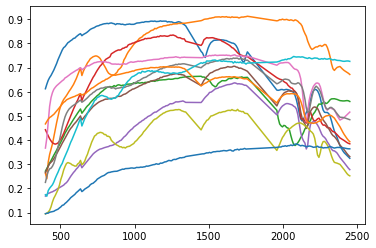

In [2]:
dataset = "cuprite"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

figure(1)
plot(wavelength, spectra[0])
plot(wavelength, spectra[1])
plot(wavelength, spectra[2])
plot(wavelength, spectra[3])
plot(wavelength, spectra[4])
plot(wavelength, spectra[5])
plot(wavelength, spectra[6])
plot(wavelength, spectra[7])
plot(wavelength, spectra[8])
plot(wavelength, spectra[9])
plot(wavelength, spectra[10])
plot(wavelength, spectra[11])
plt.show()

'cut it first, my computer cannot run the whole dataset, need to used online GPU'

# upper left corner
area_1 = hypercube[:20,:20,:]
map_1 = a_map[:20,:20,:]

#centre
area_2 = hypercube[100:120,100:120,:]
map_2 = a_map[:20,:20,:]

#endmember 6
area_3 = hypercube[100:120,130:150,:]
map_3 = a_map[100:120,130:150,:]

#endmember 7
area_4 = hypercube[230:250,100:120,:]
map_4 = a_map[230:250,100:120,:]


data_1 = np.append(area_1, area_2,axis = 0)
data_map_1 = np.append(map_1, map_2, axis = 0)

data_2 = np.append(area_3, area_4,axis = 0)
data_map_2 = np.append(map_3, map_4, axis = 0)

hypercube = np.append(data_1, data_2,axis = 1)
a_map = np.append(data_map_1, data_map_2,axis = 1)


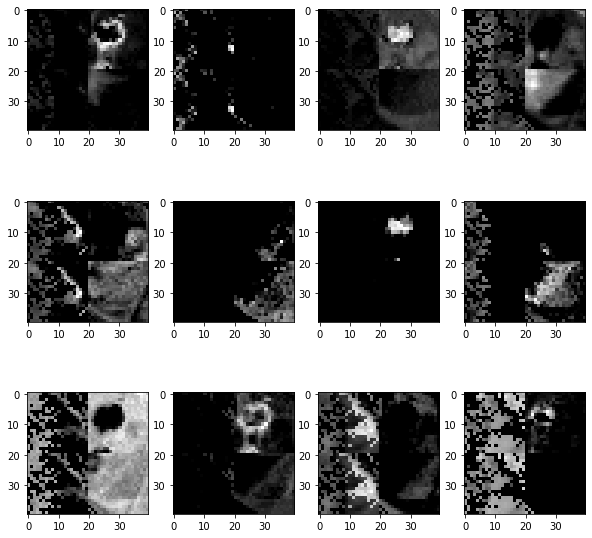

In [3]:
plt.figure(figsize=(10,10))

subplot(3,4,1)
imshow(a_map[:,:,0],cmap=cm.gray)
subplot(3,4,2)
imshow(a_map[:,:,1],cmap=cm.gray)
subplot(3,4,3)
imshow(a_map[:,:,2],cmap=cm.gray)

subplot(3,4,4)
imshow(a_map[:,:,3],cmap=cm.gray)
subplot(3,4,5)
imshow(a_map[:,:,4],cmap=cm.gray)
subplot(3,4,6)
imshow(a_map[:,:,5],cmap=cm.gray)

subplot(3,4,7)
imshow(a_map[:,:,6],cmap=cm.gray)
subplot(3,4,8)
imshow(a_map[:,:,7],cmap=cm.gray)
subplot(3,4,9)
imshow(a_map[:,:,8],cmap=cm.gray)

subplot(3,4,10)
imshow(a_map[:,:,9],cmap=cm.gray)
subplot(3,4,11)
imshow(a_map[:,:,10],cmap=cm.gray)
subplot(3,4,12)
imshow(a_map[:,:,11],cmap=cm.gray)

# RMSE

In [4]:
def compute_unmixing_accuracy(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # Take RMS difference between true abundance map and computed.
    accuracy = sqrt(mean((abundance_map.reshape((N*M,len(endmember_sig)))-predicted)**2))
    
    if not accuracy or isnan(accuracy):
        return 100.
    print('RMSE',accuracy)
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

# Classification Acc

In [5]:
from sklearn.metrics import accuracy_score

def classification_score (a_map, pred_map):
    N,M,P = a_map.shape

    a_map = a_map.reshape((N*M,P))
    
    score = zeros((N*M))
    S = zeros((P))
    pred_map = pred_map.reshape((N*M,P))
    y_true = zeros((N*M))
    y_pred = zeros((N*M))

    
    for l in range (P):
        nor = max(a_map[:,l])
        nor2 = min(a_map[:,l])
        c = 0.5*(nor+nor2)
        for k in range (N*M):
            
            y_true[k] = a_map[k,l]
            y_pred[k] = pred_map[k,l]
            y_true[k] = (y_true[k] > c)
            y_pred[k] = (y_pred[k] > c)
        S[l] = accuracy_score(y_true,y_pred)
    
    return S

# Spectral angle mapping

In [6]:
from  pysptools import distance
def spectral_angle_distance (a_map, pred_map):
    N,M,P = a_map.shape

    a_map = a_map.reshape((N*M,P))
    score = zeros((N*M))
    D = zeros((P))
    pred_map = pred_map.reshape((N*M,P))
    y_true = zeros((N*M))
    y_pred = zeros((N*M))
    
    for l in range (P):
        for k in range (N*M):
            y_true[k] = a_map[k,l]
            y_pred[k] = pred_map[k,l]
        
        D[l] = distance.SAM(y_true,y_pred)
    
    return D

In [7]:
max(a_map[1,:,1])

0.00803948100656271

In [8]:
def create_sythentic_hypercube(a_map, spectra, wavelength):
 
    '''
    Encodes a 2d image with spectral data to generate a synthetic hypercube.
    
    Inputs:
        a_map (N x M x L array) - 3D abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
             
        spectra (L x Q array) - Array of 1D spectral respones for each pixel. Number of array members
            should be equal to the maximum value in im (L). Q is sample points in wavelength space.
            
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
    
    Output:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            dimension of the hypercube.
    '''

    N,M,_ = a_map.shape
    L,Q = spectra.shape

    hypercube = zeros((N,M,Q))
    
    for i in range(L):
        hypercube += outer(a_map[:,:,i],spectra[i]).reshape((N,M,Q))

    return hypercube

In [9]:
hyper_clear = create_sythentic_hypercube(a_map, spectra, wavelength)

# Set 1

In [10]:
w = [0.0001,0.1,1]
k = [0,0,1]
distance.SAM(w,k)

0.09966870199609992

In [11]:
center_wavelengths = [2038., 2238. ,1278.  ,918.  ,438. ,1758. ,1438. ,1958., 1398. ,2278.  ,558., 1118.]
bandwidths = [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.]

In [12]:
acc,pred_map = compute_unmixing_accuracy(hypercube, a_map, spectra, wavelength, center_wavelengths, bandwidths, return_predicted=True)

RMSE 0.01778674852563636


In [13]:
hyper_pred = create_sythentic_hypercube(pred_map, spectra, wavelength)

In [14]:
N,M,P = hyper_pred.shape

In [15]:
sqrt(mean((hyper_clear-hyper_pred)**2))

0.010377339650686466

In [16]:
spectral_angle_distance (a_map, pred_map)

array([0.85607033, 1.42953435, 0.64342222, 0.92824012, 0.84796124,
       1.42889934, 0.4669331 , 0.9827781 , 0.61681947, 0.64409985,
       0.94234845, 1.34523972])

In [17]:
mean([0.85607033, 1.42953435, 0.64342222, 0.92824012, 0.84796124,
       1.42889934, 0.4669331 , 0.9827781 , 0.61681947, 0.64409985,
       0.94234845, 1.34523972])

0.9276955241666668

In [18]:
classification_score (a_map, pred_map)

array([0.9725  , 0.97625 , 0.93625 , 0.805   , 0.724375, 0.91875 ,
       0.989375, 0.950625, 0.6775  , 0.970625, 0.88125 , 0.785   ])

In [19]:
mean([0.9725  , 0.97625 , 0.93625 , 0.805   , 0.724375, 0.91875 ,
       0.989375, 0.950625, 0.6775  , 0.970625, 0.88125 , 0.785   ])

0.8822916666666667

# Set 2

In [20]:
center_wavelengths = [2402, 2016, 1920, 2094, 2008, 1046, 470, 680, 1398, 1698, 1230, 896.]
bandwidths = [20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.]

In [21]:
acc,pred_map = compute_unmixing_accuracy(hypercube, a_map, spectra, wavelength, center_wavelengths, bandwidths, return_predicted=True)

RMSE 0.016177066788866278


In [22]:
spectral_angle_distance (a_map, pred_map)

array([0.88921299, 1.10682217, 0.56288347, 0.86004149, 0.77932993,
       1.46388137, 0.11644468, 0.85934219, 0.51677825, 0.39204175,
       0.90540449, 1.33521579])

In [23]:
mean([0.88921299, 1.10682217, 0.56288347, 0.86004149, 0.77932993,
       1.46388137, 0.11644468, 0.85934219, 0.51677825, 0.39204175,
       0.90540449, 1.33521579])

0.8156165474999999

In [24]:
classification_score (a_map, pred_map)

array([0.9475  , 0.930625, 0.99875 , 0.77625 , 0.860625, 0.966875,
       0.99625 , 0.905625, 0.77    , 0.995625, 0.89    , 0.785   ])

In [25]:
mean([0.9475  , 0.930625, 0.99875 , 0.77625 , 0.860625, 0.966875,
       0.99625 , 0.905625, 0.77    , 0.995625, 0.89    , 0.785   ])

0.9019270833333334

# Published set

In [26]:
center_wavelengths = [485,560,660,830,1650,2215]
bandwidths = [35,40,30,70,100,135]

In [27]:
acc,pred_map = compute_unmixing_accuracy(hypercube, a_map, spectra, wavelength, center_wavelengths, bandwidths, return_predicted=True)

RMSE 0.02153354461951278


In [28]:
spectral_angle_distance (a_map, pred_map)

/opt/anaconda3/lib/python3.8/site-packages/pysptools/distance/dist.py:49: RuntimeWarning: invalid value encountered in double_scalars
  angle = math.acos(sum_s1_s2 / (s1_norm * s2_norm))


array([1.04055955, 1.38983711, 1.3299635 , 0.7789186 , 0.74266318,
              nan, 0.49085553, 1.18100263, 0.99873404, 0.8419917 ,
       1.0604347 , 1.49577681])

In [29]:
mean([1.04055955, 1.38983711, 1.3299635 , 0.7789186 , 0.74266318,
              0, 0.49085553, 1.18100263, 0.99873404, 0.8419917 ,
       1.0604347 , 1.49577681])

0.9458947791666668

In [30]:
classification_score (a_map, pred_map)

array([0.929375, 0.929375, 0.899375, 0.72    , 0.578125, 0.980625,
       0.991875, 0.67875 , 0.481875, 0.919375, 0.895625, 0.7825  ])

In [31]:
mean([0.929375, 0.929375, 0.899375, 0.72    , 0.578125, 0.980625,
       0.991875, 0.67875 , 0.481875, 0.919375, 0.895625, 0.7825  ])

0.8155729166666666